In [42]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 8]
import cv2
import numpy as np


In [43]:
def imshow(image):
    if (len(image.shape)==2):
        plt.imshow(image,cmap="gray")
    else:
        plt.imshow(image[:,:,::-1])
def resize(img, ratio):
    width = int(img.shape[1] * ratio)
    height = int(img.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

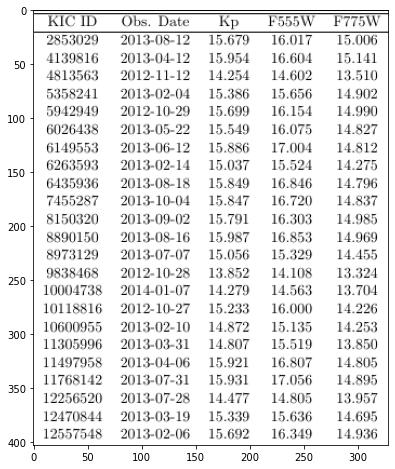

In [116]:
# image for demo: 48866(anh mau), 19(anh khong duong), 32(anh co duong), 49392(anh ghep nhieu hang)
image = cv2.imread('train/75011.png')
result = image.copy()
imshow(result)

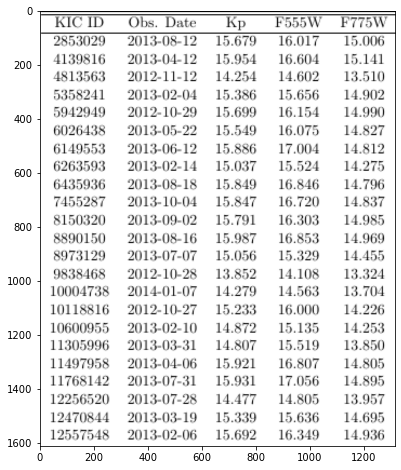

In [117]:
result = resize(result, 4)
# result=cv2.pyrUp(result)
# result=cv2.pyrUp(result)
imshow(result)

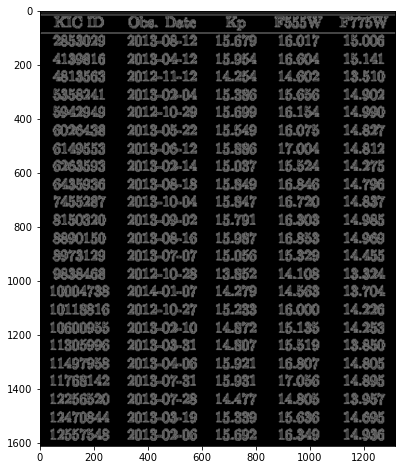

In [118]:
gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)   

canny = cv2.Canny(gray, 10, 50)
cannyres = canny.copy()
imshow(canny)

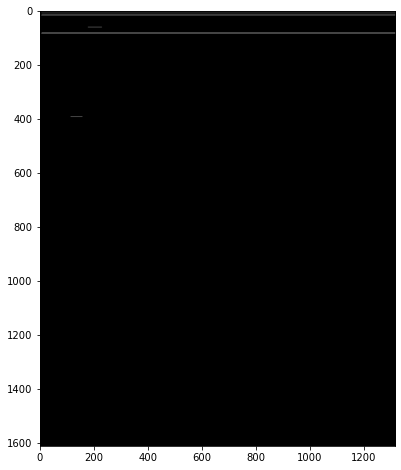

In [119]:
# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
remove_horizontal = cv2.morphologyEx(cannyres, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
imshow(remove_horizontal)


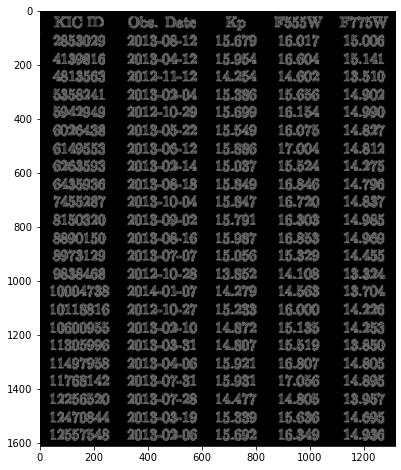

In [120]:

cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(canny, [c], -1, (0,0,0), 2)
imshow(canny)

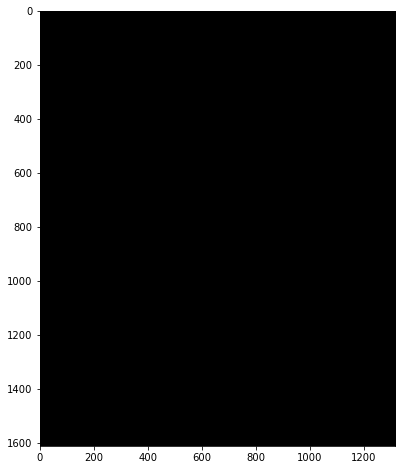

In [121]:
# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,28))
remove_vertical = cv2.morphologyEx(cannyres, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
imshow(remove_vertical)


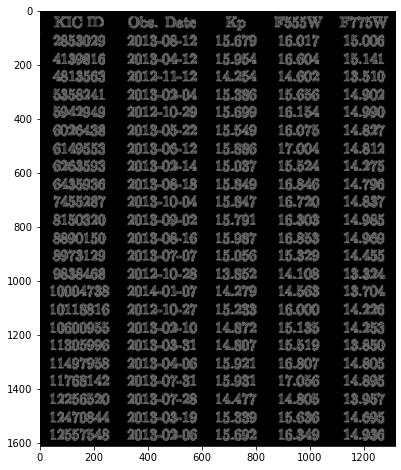

In [122]:
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(canny, [c], -1, (0,0,0), 4)
imshow(canny)

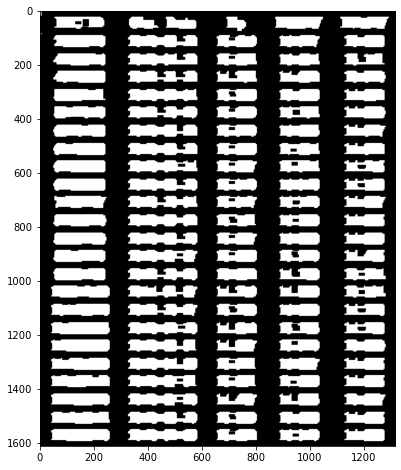

In [123]:
#connected = thresh.copy()
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 6))
connected = cv2.dilate(canny, kernel, iterations=2)
connected = cv2.erode(connected, kernel, iterations=2)
imshow(connected)

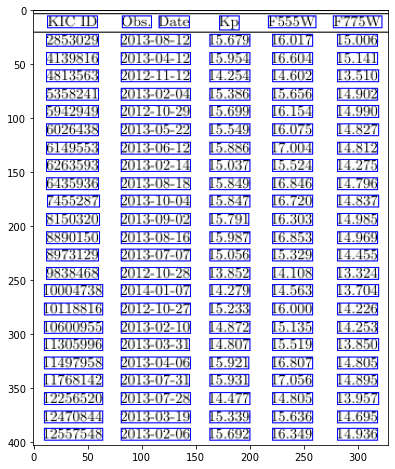

In [124]:
n_connected = resize(connected, 1/4)
contours, hierarchy = cv2.findContours(n_connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

image1 = image.copy()
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    
    if w > 4 and h > 4:
        cv2.rectangle(image1, (x, y), (x+w-1, y+h-1), (255, 0, 0), 1)
imshow(image1)